In [1761]:
#Import Tools
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
import openpyxl

In [1762]:
# Gives adjacency dictionary (not mine)
edge_dict={}
def create_edge_dict(graph):
    for i, n in G.adjacency():
        # print("i is",i)
        # print("n is",n)
        edge_dict[i] = list(n)
    return edge_dict

# Gives duplicate items in a list (not mine)
def list_duplicates(seq):
  seen = set()
  seen_add = seen.add
  # adds all elements it doesn't know yet to seen and all other to seen_twice
  seen_twice = set( x for x in seq if x in seen or seen_add(x) )
  # turn the set into a list (as requested)
  return list( seen_twice )


#(https://www.geeksforgeeks.org/python-merge-two-lists-into-list-of-tuples/)
def merge(list1, list2):
      
    merged_list = []
    for i in range(max((len(list1), len(list2)))):
  
        while True:
            try:
                tup = (list1[i], list2[i])
            except IndexError:
                if len(list1) > len(list2):
                    list2.append('')
                    tup = (list1[i], list2[i])
                elif len(list1) < len(list2):
                    list1.append('')
                    tup = (list1[i], list2[i])
                continue
  
            merged_list.append(tup)
            break
    return merged_list


# function to check whether the list is empty or not
def is_list_empty(list):
    # checking the length
    if len(list) == 0:
        # returning true as length is 0
        return True
    # returning false as length is greater than 0
    return False

In [1763]:
# #retrieve data regarding vacant spaces
from openpyxl import load_workbook
workbook = load_workbook(filename="Node_Information_TU.xlsx")
workbook.sheetnames
sheet1 = workbook.worksheets[0]
sheet2 = workbook.worksheets[1]

# #create dictionary based on excel worksheet
vacant_spaces={}
for value in sheet1.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
        vacant_spaces[value[0]]={}
        vacant_spaces[value[0]]["location"]=value[1]
        vacant_spaces[value[0]]["tag"]=value[6]
        vacant_spaces[value[0]]["building"]=value[3]
        vacant_spaces[value[0]]["size_real"]=int(value[2])
        vacant_spaces[value[0]]["loc_building"]=value[4]
        vacant_spaces[value[0]]["orientation"]=value[5]
        vacant_spaces[value[0]]["node_type"]=value[7]

#interpret data
#Rules:
#structure (roof:1,ground:3,outside:3,basement:3,intermediate:2)
#solar (roof:3,
#       basement:1
#       ground & S,SW,SE:3,
#       ground $ E,W:2
#       ground $ N,NE,NW:1
#       outside & S,SW,SE:3,
#       outside $ E,W:2
#       outside $ N,NE,NW:1
#       intermediate & S,SW,SE:3,
#       intermediate & E,W:2
#       intermediate & N,NE,NW:1
#size (0-100 size:1)
#     (101-500 size:2)
#     (500-... size:3)

for space in vacant_spaces:
    if vacant_spaces[space]["loc_building"]=="roof":
        vacant_spaces[space]["structure"]=1
        vacant_spaces[space]["solar"]=3
    if vacant_spaces[space]["loc_building"]=="basement":
        vacant_spaces[space]["structure"]=3
        vacant_spaces[space]["solar"]=1
    if (vacant_spaces[space]["loc_building"]=="ground") and (((vacant_spaces[space]["orientation"])=="S") or ((vacant_spaces[space]["orientation"])=="SE") or ((vacant_spaces[space]["orientation"])=="SW")):
        vacant_spaces[space]["solar"]=3
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="ground") and (((vacant_spaces[space]["orientation"])=="N") or ((vacant_spaces[space]["orientation"])=="NE") or ((vacant_spaces[space]["orientation"])=="NW")):
        vacant_spaces[space]["solar"]=1
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="ground") and (((vacant_spaces[space]["orientation"])=="E") or ((vacant_spaces[space]["orientation"])=="W")):
        vacant_spaces[space]["solar"]=2
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="intermediate") and (((vacant_spaces[space]["orientation"])=="S") or ((vacant_spaces[space]["orientation"])=="SE") or ((vacant_spaces[space]["orientation"])=="SW")):
        vacant_spaces[space]["solar"]=3
        vacant_spaces[space]["structure"]=2
    if (vacant_spaces[space]["loc_building"]=="intermediate") and (((vacant_spaces[space]["orientation"])=="N") or ((vacant_spaces[space]["orientation"])=="NE") or ((vacant_spaces[space]["orientation"])=="NW")):
        vacant_spaces[space]["solar"]=1
        vacant_spaces[space]["structure"]=2
    if (vacant_spaces[space]["loc_building"]=="intermediate") and (((vacant_spaces[space]["orientation"])=="E") or ((vacant_spaces[space]["orientation"])=="W")):
        vacant_spaces[space]["solar"]=2
        vacant_spaces[space]["structure"]=2
    if (vacant_spaces[space]["loc_building"]=="outside") and (((vacant_spaces[space]["orientation"])=="S") or ((vacant_spaces[space]["orientation"])=="SE") or ((vacant_spaces[space]["orientation"])=="SW")):
        vacant_spaces[space]["solar"]=3
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="outside") and (((vacant_spaces[space]["orientation"])=="N") or ((vacant_spaces[space]["orientation"])=="NE") or ((vacant_spaces[space]["orientation"])=="NW")):
        vacant_spaces[space]["solar"]=1
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="outside") and (((vacant_spaces[space]["orientation"])=="E") or ((vacant_spaces[space]["orientation"])=="W")):
        vacant_spaces[space]["solar"]=2
        vacant_spaces[space]["structure"]=3

#interpret size based on predefined ranges
for space in vacant_spaces:
    if vacant_spaces[space]["size_real"]<=100:
        vacant_spaces[space]["size"]=1
    if (vacant_spaces[space]["size_real"]>100) and (vacant_spaces[space]["size_real"]<=500) :
        vacant_spaces[space]["size"]=2
    if (vacant_spaces[space]["size_real"]>500):
        vacant_spaces[space]["size"]=3
    
#remove orientation,loc_building,size_real
for space in vacant_spaces:
    vacant_spaces[space].pop("orientation")
    vacant_spaces[space].pop("size_real")
    vacant_spaces[space].pop("loc_building")   
     
#retrieve waste sources
#create dictionary based on excel worksheet
wastes={}
for value in sheet2.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
            wastes[value[0]]={}
            wastes[value[0]]["location"]=value[1]
            wastes[value[0]]["tag"]=value[5]
            wastes[value[0]]["type"]=value[3]
# print(wastes)

In [1764]:
#retrieve connections within radius=x
url = "https://raw.githubusercontent.com/erengozdeanil/UF-DecisionMaker/main/Edges1.txt"
resp = requests.get(url)
edges = json.loads(resp.text)
#converts nested lists into a list of tuples
edge_coordinates100 = [tuple(i) for i in edges]


#retrieve connections between vacant spaces within radius=x
url1="https://raw.githubusercontent.com/erengozdeanil/UF-DecisionMaker/main/Edges_vacant100.txt"
resp1 = requests.get(url1)
edges1 = json.loads(resp1.text)
#converts nested lists into a list of tuples
nearby_space_coordinates = [tuple(i) for i in edges1]

#retrieve connections within radius=3x

#combine wastes and vacant_spaces
combined_dict=vacant_spaces.copy()
combined_dict.update(wastes)
# print(edge_coordinates100)

#replace coordinates with identifiers
# FOR NEARBY WASTE100
nearby_waste100=[]
for couple in edge_coordinates100:
    for space in vacant_spaces:
        for waste in wastes:
            if couple[0]==vacant_spaces[space]["location"]:
                if couple[1]==wastes[waste]["location"]:
                    edge_tuple=(space,waste)
                    nearby_waste100.append(edge_tuple)

print(nearby_waste100,len(nearby_waste100))


[('V0', 'WO74'), ('V0', 'WO77'), ('V1', 'WO56'), ('V1', 'WO27'), ('V1', 'WO54'), ('V1', 'WO26'), ('V3', 'WO42'), ('V3', 'WO1'), ('V3', 'WO7'), ('V3', 'WO5'), ('V3', 'WO2'), ('V3', 'WO8'), ('V3', 'WO6'), ('V3', 'WO3'), ('V5', 'WO53'), ('V5', 'WO52'), ('V5', 'WO51'), ('V5', 'WO60'), ('V5', 'WO50'), ('V5', 'WO66'), ('V6', 'WO2'), ('V6', 'WO5'), ('V6', 'WO1'), ('V9', 'WO81'), ('V9', 'WO80'), ('V10', 'WO68'), ('V10', 'WO72'), ('V11', 'WO69'), ('V13', 'WO40'), ('V13', 'WO37'), ('V13', 'WO17'), ('V13', 'WO35'), ('V13', 'WO21'), ('V13', 'WO41'), ('V13', 'WO38'), ('V13', 'WO18'), ('V13', 'WO22'), ('V14', 'WO9'), ('V14', 'WO10'), ('V16', 'WO71'), ('V23', 'WO45'), ('V23', 'WO44'), ('V23', 'WO43'), ('V23', 'WO14'), ('V23', 'WO41'), ('V23', 'WO34'), ('V23', 'WO46'), ('V23', 'WO39'), ('V23', 'WO15'), ('V23', 'WO38'), ('V23', 'WO37'), ('V23', 'WO36'), ('V28', 'WO16'), ('V28', 'WO20'), ('V28', 'WO19'), ('V29', 'WO83'), ('V29', 'WO70'), ('V30', 'WO83'), ('V30', 'WO70'), ('V33', 'WO71'), ('V41', 'WO79')

In [1765]:

# FOR NEARBY SPACE
start1=[]
end1=[]
nearby_space100=[]
for couple in nearby_space_coordinates:
    for space1 in vacant_spaces:
        for space2 in combined_dict:
            if couple[0]==vacant_spaces[space1]["location"]:
                if couple[1]==combined_dict[space2]["location"]:
                    new_tuple=(space1,space2) 
                    reverse=(space2,space1) 
                    if reverse not in nearby_space100:
                        nearby_space100.append(new_tuple)

# print(nearby_space100,len(nearby_space100))

In [1766]:

for waste in wastes:
    for couple in nearby_waste100:
        if wastes[waste]["type"]=="None":
            if waste in couple:
                print(couple, "removed")
                nearby_waste100.remove(couple)
                (couple,"removed")
# print(nearby_waste100,len(nearby_waste100))

('V23', 'WO15') removed
('V83', 'WO15') removed
('V23', 'WO46') removed
('V130', 'WO46') removed
('V16', 'WO71') removed
('V33', 'WO71') removed
('V48', 'WO71') removed


In [1767]:
workbook = load_workbook(filename="Node_Information_TU.xlsx")
workbook.sheetnames
sheet1 = workbook.worksheets[0]
sheet2 = workbook.worksheets[1]
wastes={}
for value in sheet2.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
        if value[4]!=0:
            wastes[value[0]]={}
            wastes[value[0]]["location"]=value[1]
            wastes[value[0]]["source"]=value[2]
            wastes[value[0]]["tag"]=value[5]
            wastes[value[0]]["type"]=value[3]
            wastes[value[0]]["quantity"]=int(value[4])
            wastes[value[0]]["node_type"]="waste"


#assign ranges to quantities
for waste in wastes:
    if wastes[waste]["type"]=="W1":
        if wastes[waste]["quantity"]<= 91852:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>91852) and (wastes[waste]["quantity"]<=459261):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>459261:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W2":
        if wastes[waste]["quantity"]<= 25000:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>25000) and (wastes[waste]["quantity"]<=125000):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>125000:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W3":
        if wastes[waste]["quantity"]<= 5906:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>5906) and (wastes[waste]["quantity"]<=29531):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>29531:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W4":
        if wastes[waste]["quantity"]<= 14100:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>14100) and (wastes[waste]["quantity"]<=70500):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>70500:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W5":
        if wastes[waste]["quantity"]<= 7937:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>7937) and (wastes[waste]["quantity"]<=39684):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>39684:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W6":
        if wastes[waste]["quantity"]<= 187612:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>187612) and (wastes[waste]["quantity"]<=938060):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>938060:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W7":
        if wastes[waste]["quantity"]<= 100000:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>100000) and (wastes[waste]["quantity"]<=500000):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>500000:
            wastes[waste]["size"]=3
# #remove quantity
for waste in wastes:
    wastes[waste].pop("quantity")

In [1768]:
#Dictionary of urban farming systems
    # UF1: Vermiculture, UF2: Aquaculture, UF3: Mushroom, UF4: NFT, UF5: Medai Beds, UF6: Raised Beds, UF7: Water Culture, UF8: Plant Factory, UF9: Aeroponics
    # "S" : supplementary system, "F" : food production system
    # 3 : high, 2 : medium, 1 : low, 0 : none
uf_systems = {
"UF1":{"tag":"UF1","type":"S","weight":3,"solar":1,"in":["W1","W2","W3","W6"],"supplement":None,"out":["S4","S5"]},
"UF2":{"tag":"UF2","type":"SF","weight":3,"solar":2,"in":["W7"],"supplement":["S5"],"out":["O4","S2"]},
"UF3":{"tag":"UF3","type":"F","weight":2,"solar":1,"in":["W2","W3","W4","W6"],"supplement":None,"out":["O3","S4"]},
"UF4":{"tag":"UF4","type":"F","weight":1,"solar":3,"in":["W5","W6","W7"],"supplement":["S2"],"out":["O1","W1"]},
"UF5":{"tag":"UF5","type":"F","weight":1,"solar":3,"in":["W5","W6","W7"],"supplement":["S2"],"out":["O1","O2","W1"]},
"UF6":{"tag":"UF6","type":"F","weight":3,"solar":3,"in":["W6"],"supplement":["S4"],"out":["O1","O2","W1"]},
"UF7":{"tag":"UF7","type":"F","weight":3,"solar":3,"in":["W5","W6","W7"],"supplement":["S2"],"out":["O1","W1"]},
"UF8":{"tag":"UF8","type":"F","weight":3,"solar":1,"in":["W5","W6"],"supplement":["S2"],"out":["O1","W1","W7"]},
"UF9":{"tag":"UF9","type":"F","weight":1,"solar":3,"in":["W5","W6","W7"],"supplement":["S2"],"out":["O1","W1"]}
}

critical_items=["W1","W2","W3", "W4"]
non_critical_items=["W5","W6","W7"]

In [1769]:
# print(nearby_waste100,len(nearby_waste100))

0. Prepare Data For Decision Making

In [1802]:
#Make a dictionary of vacant spaces and potential uf systems
v_potential = {}
for k,v in vacant_spaces.items():
    uf_list=[]
    for j,y in uf_systems.items():
        if (vacant_spaces[k]["structure"])>=(uf_systems[j]["weight"]) and (vacant_spaces[k]["solar"])==(uf_systems[j]["solar"]) and (uf_systems[j]["type"]=="F"):
            v_potential[k]={}
            uf_list.append(uf_systems[j]["tag"])
            v_potential[k]["tag"]=vacant_spaces[k]["tag"]
            v_potential[k]["UF"]=uf_list
# print(v_potential)

for couple in nearby_waste100:
    for index,item in enumerate(couple):
        if vacant_spaces[couple[0]]["building"]!=wastes[couple[1]]["source"]:
            print(couple,vacant_spaces[couple[0]]["building"],wastes[couple[1]]["source"],wastes[couple[1]]["type"])
            if (wastes[couple[1]]["type"]=="W5") or (wastes[couple[1]]["type"]=="W6") or (wastes[couple[1]]["type"]=="W7"):
                print(couple,wastes[couple[1]]["type"])
                if couple in nearby_waste100:
                    print("removed",couple,wastes[couple[1]]["type"],vacant_spaces[couple[0]]["building"],wastes[couple[1]]["source"],wastes[couple[1]]["type"])
                    nearby_waste100.remove(couple)
                    

print(nearby_waste100)  


('V0', 'WO74') outside AS2 W4
('V0', 'WO74') outside AS2 W4
('V1', 'WO56') outside CEG W5
('V1', 'WO56') W5
removed ('V1', 'WO56') W5 outside CEG W5
('V1', 'WO56') outside CEG W5
('V1', 'WO56') W5
('V5', 'WO53') outside EEMCS2 W3
('V5', 'WO53') outside EEMCS2 W3
('V5', 'WO51') outside EEMCS2 W5
('V5', 'WO51') W5
removed ('V5', 'WO51') W5 outside EEMCS2 W5
('V5', 'WO51') outside EEMCS2 W5
('V5', 'WO51') W5
('V5', 'WO66') outside CEG W3
('V5', 'WO66') outside CEG W3
('V6', 'WO2') outside BK W1
('V6', 'WO2') outside BK W1
('V6', 'WO1') outside BK W2
('V6', 'WO1') outside BK W2
('V9', 'WO80') outside AE W5
('V9', 'WO80') W5
removed ('V9', 'WO80') W5 outside AE W5
('V9', 'WO80') outside AE W5
('V9', 'WO80') W5
('V11', 'WO69') outside X W4
('V11', 'WO69') outside X W4
('V13', 'WO40') outside 3me W4
('V13', 'WO40') outside 3me W4
('V13', 'WO17') outside foodtrucks W1
('V13', 'WO17') outside foodtrucks W1
('V13', 'WO21') outside Aula W5
('V13', 'WO21') W5
removed ('V13', 'WO21') W5 outside Aul

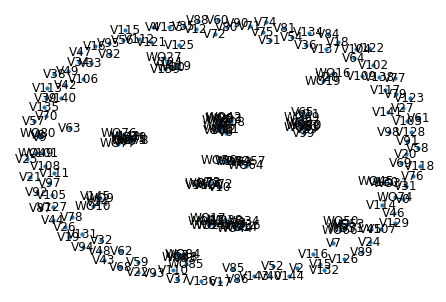

In [1771]:
# Draw Graph with nodes and edges with coordinates
G=nx.Graph()
for i,j in vacant_spaces.items():
    G.add_node(i)
G.add_edges_from(nearby_waste100)
nx.draw(G, with_labels=True, node_size=10)

# Create a dictionary with vacant spaces and waste outputs them
new_waste_dict = create_edge_dict(G)
waste_dict = {}
for i,k in new_waste_dict.items():
    if i in vacant_spaces:
        waste_dict[i]=k
        
#List of dictionaries we will use:
# print(v_potential)
# print(waste_dict)
# print(uf_systems)

# add needed inputs for each potential system into the v_potential dictionary
v_potential_dict={}
for i,k in v_potential.items():
    v_potential_dict[i]={}
    potential_systems = v_potential[i]["UF"]
    for item in potential_systems:
       v_potential_dict[i][item] = uf_systems[item]["in"]
        
#Design Rule 1.0 : Waste Availability
    #if there are more than 2 found items assign that system to that vacant space
    
    

Design Rule 3.0 : Sharing Existing Resources
    

Prepare Data

In [1772]:
# Preparation of Data
#Make a dictionary of found items nearby for each potential uf system
found_dict={}

for i,k in v_potential_dict.items():
    found_dict[i]={}
    for system,demanded in k.items():
        found_dict[i][system]={}
        found_dict[i][system]["found"]={}
        found_dict[i][system]["source"]={}
        found=[]
        source=[]
        for waste in waste_dict[i]:
            for each in demanded: 
                available = wastes[waste]["type"]
                source2 = wastes[waste]["tag"]
                print(i,wastes[waste])
                source_size = wastes[waste]["size"]
                if each == available:
                    found.append(available)
                    source.append(source2)
                    found_dict[i][system]["found"]=found
                    found_dict[i][system]["source"]=source


V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'waste', 'size': 1}
V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'waste', 'size': 1}
V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'waste', 'size': 1}
V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'waste', 'size': 1}
V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'waste', 'size': 1}
V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'waste', 'size': 1}
V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'waste', 'size': 1}
V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'was

In [1773]:
#Make a dictionary of missing for each potential uf system           
for i,system in found_dict.items():
    for uf in system:
        missing=[]
        found_dict[i][uf]["missing"]={}
        for x,y in uf_systems.items():
            for item in uf_systems[x]["in"]:
                if uf == x:
                    missing.append(item)
                    found_dict[i][uf]["missing"]=missing
        
#In the dictionary missing items also contain found items
for i,k in found_dict.items():
    for system in k:
        for item in (found_dict[i][system]["found"]):
            if item in found_dict[i][system]["missing"]:
                missing_list=found_dict[i][system]["missing"]
                missing_list.remove(item)

#reach sizes of duplicate items
for i,k in found_dict.items():
    for system in k:
        found_items=found_dict[i][system]["found"]


In [1774]:
#add a new list to the found dict -> for 1 waste source matching the size of space
for space in found_dict:
    for system in found_dict[space]:
        found_dict[space][system]["enough waste"]=[]
        found_dict[space][system]["enough source"]=[]
        for item in found_dict[space][system]["source"]:
            if wastes[item]["size"]==vacant_spaces[space]["size"]:
                if found_dict[space][system]["enough waste"]==[]:
                    print(space,system,item,wastes[item]["type"],"1")
                    found_dict[space][system]["enough waste"].append(wastes[item]["type"])
                    found_dict[space][system]["enough source"].append(wastes[item]["tag"])
                    found_dict[space][system]["found"].remove(wastes[item]["type"])
                    found_dict[space][system]["source"].remove(wastes[item]["tag"])
                    break
                elif found_dict[space][system]["enough waste"]!=[]:
                    for waste in found_dict[space][system]["enough waste"]:
                        if wastes[waste]["type"]!=wastes[item]["type"]:
                            print(space,system,item,wastes[item]["type"],"2")
                            found_dict[space][system]["enough waste"].append(wastes[item]["type"])
                            found_dict[space][system]["enough source"].append(wastes[item]["tag"])
                            found_dict[space][system]["found"].remove(wastes[item]["type"])
                            found_dict[space][system]["source"].remove(wastes[item]["tag"])

# print(found_dict)

V3 UF3 WO42 W6 1
V3 UF8 WO42 W6 1
V119 UF4 WO0 W7 1
V119 UF5 WO0 W7 1
V119 UF7 WO0 W7 1
V119 UF9 WO0 W7 1
V124 UF4 WO0 W7 1
V124 UF5 WO0 W7 1
V124 UF7 WO0 W7 1
V124 UF9 WO0 W7 1
V142 UF4 WO76 W5 1
V142 UF5 WO76 W5 1
V142 UF7 WO76 W5 1
V142 UF9 WO76 W5 1


In [1775]:

#Make a dictionary holding each vacant space& found and repeating waste type & waste sources corresponding to found items
duplicate_items={}
for space,potential in found_dict.items():
    duplicate_items[space]={}
    for system, k in potential.items():
        if len(found_dict[space][system]["found"])> 1:
            found_items3=found_dict[space][system]["found"]
            sources=[]
            for index,items in enumerate(found_items3):
                duplicate_items[space][items]={}
                count=found_items3.count(items)
                if count>1:
                    items_str=str(items)
                    sources.append(found_dict[space][system]["source"][index])
                    duplicate_items[space][items]["matching sources"]=sources


In [1776]:
print(found_dict["V3"])

{'UF3': {'found': ['W2', 'W3'], 'source': ['WO1', 'WO3'], 'missing': ['W4'], 'enough waste': ['W6'], 'enough source': ['WO42']}, 'UF8': {'found': ['W5', 'W5', 'W5', 'W5'], 'source': ['WO7', 'WO5', 'WO8', 'WO6'], 'missing': [], 'enough waste': ['W6'], 'enough source': ['WO42']}}


In [1777]:
# check if the total size of found waste matches the vacant space size

satisfying_duplicate={}
not_enough_waste={}
for space, k in duplicate_items.items():
    print(space)
    satisfying_duplicate[space]={}
    not_enough_waste[space]={}
    for key,value in k.items():
        print(key)
        satisfying_duplicate[space][key]={}
        not_enough_waste[space][key]={}
        waste_matched=[]
        not_matched=[]
        if duplicate_items[space][key]!=[]:
            for m,n in duplicate_items[space][key].items():
                matched=duplicate_items[space][key][m]
                found_new=[]
                for items in matched:
                    found_new.append(items)
                    waste_matched.append(wastes[items]["size"])
                    if sum(waste_matched)==vacant_spaces[space]["size"]:
                        print(space,vacant_spaces[space]["size"], waste_matched, "add to found list and remove from missing")
                        print(found_new, "is found")
                        print(waste_matched)
                        satisfying_duplicate[space][key]=found_new
                        break
                    else:
                        # print(sum(waste_matched),"And",vacant_spaces[space]["size"],items)
                        not_matched.append(items)
                        print(not_matched,"is not matched")
                        not_enough_waste[space][key]=not_matched
                    
                    
print(satisfying_duplicate)
print(not_matched)

V0
V1
V2
V3
W2
W3
W5
['WO7'] is not matched
['WO7', 'WO5'] is not matched
V3 3 [1, 1, 1] add to found list and remove from missing
['WO7', 'WO5', 'WO8'] is found
[1, 1, 1]
V4
V5
W5
['WO51'] is not matched
['WO51', 'WO50'] is not matched
V6
V7
V8
V9
V10
V11
V12
V13
W5
['WO21'] is not matched
['WO21', 'WO38'] is not matched
V13 3 [1, 1, 1] add to found list and remove from missing
['WO21', 'WO38', 'WO22'] is found
[1, 1, 1]
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
W5
['WO44'] is not matched
['WO44', 'WO38'] is not matched
V24
V25
V26
V27
V28
V29
V30
V31
V32
V33
V34
V35
V36
V37
V38
V39
V40
V41
V42
V43
V44
V45
V46
V47
V48
V49
V50
V51
V52
V53
W5
['WO64'] is not matched
['WO64', 'WO57'] is not matched
V54
V55
V56
V57
V58
V59
V60
V61
V62
V63
V64
V65
V66
V67
V68
V69
V70
V71
V72
V73
V74
V75
V76
V77
V78
V79
V80
V81
V82
V83
V84
V85
V86
V87
V88
V89
V90
V91
V92
V93
V94
V95
V96
V97
V98
V99
V100
V101
V102
V103
V104
V105
V106
V107
V108
V109
V110
V111
V112
V113
V114
V115
V116
V117
V118
V119
V120
V121
V1

In [1778]:
#remove duplicate items if they are also in satisfying_duplicate items list
for space,potential in found_dict.items():
    for system in potential.keys():
        for key, value in satisfying_duplicate.items():
            for waste in value.keys():
                if key==space:
                        if len(found_dict[space][system]["found"])>0:
                            print("there are found items")
                            if len(satisfying_duplicate[key][waste])>0:
                                print("there are satisfying duplicate items")
                                if waste in found_dict[space][system]["found"]:
                                    print(waste,"is in found dict",space,system)
                                    found_items = found_dict[space][system]["found"]
                                    found_dict[space][system]["enough waste"].append(waste)
                                    for item in satisfying_duplicate[key][waste]:
                                        found_dict[space][system]["enough source"].append(item)
                                        found_dict[space][system]["source"].remove(item)
                                    for found_range in range(len(found_items)):
                                        for found in found_items:
                                            print(found_items,space,system)
                                            counter=found_items.count(found)
                                            print(waste,counter,space,system)
                                            if counter>1:
                                                print(found,"REMOVED",space,system)  
                                                found_items.remove(found)


there are found items
there are found items
there are found items
there are satisfying duplicate items
there are found items
there are found items
there are found items
there are satisfying duplicate items
W5 is in found dict V3 UF8
['W5', 'W5', 'W5', 'W5'] V3 UF8
W5 4 V3 UF8
W5 REMOVED V3 UF8
['W5', 'W5', 'W5'] V3 UF8
W5 3 V3 UF8
W5 REMOVED V3 UF8
['W5', 'W5'] V3 UF8
W5 2 V3 UF8
W5 REMOVED V3 UF8
['W5'] V3 UF8
W5 1 V3 UF8
['W5'] V3 UF8
W5 1 V3 UF8
there are found items
there are found items
there are found items
there are found items
there are found items
there are satisfying duplicate items
W5 is in found dict V13 UF4
['W5', 'W5', 'W5'] V13 UF4
W5 3 V13 UF4
W5 REMOVED V13 UF4
['W5', 'W5'] V13 UF4
W5 2 V13 UF4
W5 REMOVED V13 UF4
['W5'] V13 UF4
W5 1 V13 UF4
['W5'] V13 UF4
W5 1 V13 UF4
there are found items
there are satisfying duplicate items
W5 is in found dict V13 UF5
['W5', 'W5', 'W5'] V13 UF5
W5 3 V13 UF5
W5 REMOVED V13 UF5
['W5', 'W5'] V13 UF5
W5 2 V13 UF5
W5 REMOVED V13 UF5
['W5'

In [1779]:
#remove duplicate items if they are not in satisfying_duplicate items list
print(found_dict["V2"])
for space in found_dict.keys():
    for system in found_dict[space].keys():
        found_items = found_dict[space][system]["found"]
        missing_items = found_dict[space][system]["missing"]
        duplicate=list_duplicates(found_items)
        for key, value in satisfying_duplicate.items():
            for waste in value.keys():
                if key==space:
                    for found in found_items:
                        if found in duplicate:
                            print("duplicate",space,found,system)
                            if satisfying_duplicate[space][found]==[]:
                                print("duplicate not satisfying",space,found,system)
                                found_items.remove(found) 
                                if found not in missing_items:
                                    missing_items.append(found)
                                if (found in missing_items) and (found in found_items):
                                    found_items.remove(found)            
                                
print(found_dict["V3"])

{'UF4': {'found': {}, 'source': {}, 'missing': ['W5', 'W6', 'W7'], 'enough waste': [], 'enough source': []}, 'UF5': {'found': {}, 'source': {}, 'missing': ['W5', 'W6', 'W7'], 'enough waste': [], 'enough source': []}, 'UF9': {'found': {}, 'source': {}, 'missing': ['W5', 'W6', 'W7'], 'enough waste': [], 'enough source': []}}
duplicate V5 W5 UF4
duplicate V5 W5 UF4
duplicate V5 W5 UF5
duplicate V5 W5 UF5
duplicate V5 W5 UF7
duplicate V5 W5 UF7
duplicate V5 W5 UF9
duplicate V5 W5 UF9
duplicate V23 W5 UF4
duplicate V23 W5 UF4
duplicate V23 W5 UF5
duplicate V23 W5 UF5
duplicate V23 W5 UF7
duplicate V23 W5 UF7
duplicate V23 W5 UF9
duplicate V23 W5 UF9
duplicate V53 W5 UF4
duplicate V53 W5 UF4
duplicate V53 W5 UF5
duplicate V53 W5 UF5
duplicate V53 W5 UF7
duplicate V53 W5 UF7
duplicate V53 W5 UF9
duplicate V53 W5 UF9
{'UF3': {'found': ['W2', 'W3'], 'source': ['WO1', 'WO3'], 'missing': ['W4'], 'enough waste': ['W6'], 'enough source': ['WO42']}, 'UF8': {'found': ['W5'], 'source': ['WO6'], 'missi

In [1780]:
for space in found_dict:
    for system in found_dict[space]:
        source=found_dict[space][system]["source"]
        for index,item in enumerate(source):
            waste=wastes[item]["type"]
            if waste in found_dict[space][system]["found"]:
                print("found",space,item,waste)
            else:
                source.remove(item)
                print(item,"removed from",space,system,waste)
 

found V1 WO56 W5
found V1 WO56 W5
found V1 WO56 W5
found V1 WO56 W5
found V3 WO1 W2
found V3 WO3 W3
found V3 WO6 W5
found V5 WO51 W5
found V5 WO50 W5
found V5 WO51 W5
found V5 WO50 W5
found V5 WO51 W5
found V5 WO50 W5
found V5 WO51 W5
found V5 WO50 W5
found V9 WO80 W5
found V9 WO80 W5
found V9 WO80 W5
found V9 WO80 W5
found V23 WO44 W5
found V23 WO38 W5
found V23 WO44 W5
found V23 WO38 W5
found V23 WO44 W5
found V23 WO38 W5
found V23 WO44 W5
found V23 WO38 W5
found V28 WO19 W5
found V28 WO19 W5
found V28 WO19 W5
found V28 WO19 W5
found V53 WO64 W5
found V53 WO57 W5
found V53 WO64 W5
found V53 WO57 W5
found V53 WO64 W5
found V53 WO57 W5
found V53 WO64 W5
found V53 WO57 W5
found V66 WO77 W5
found V66 WO77 W5
found V66 WO77 W5
found V66 WO77 W5
found V83 WO85 W5
found V83 WO85 W5
found V83 WO85 W5
found V83 WO85 W5
found V100 WO5 W5
found V100 WO5 W5
found V100 WO5 W5
found V100 WO5 W5
found V101 WO49 W5
found V101 WO49 W5
found V101 WO49 W5
found V101 WO49 W5
found V124 WO27 W5
found V12

In [1781]:
#add circularity percentage to found_dict
for space in found_dict:
    for system in found_dict[space]:
        found_dict[space][system]["circularity"]=[]
        found=len(found_dict[space][system]["enough waste"])
        missing=len(found_dict[space][system]["missing"])
        total=found+missing
        found_dict[space][system]["circularity"]=found/total
# print(found_dict)   

#make a duplicate of found dict, sort system based on circularities
sorted_dict={}
for space in found_dict:
    system=sorted(found_dict[space], key=lambda x: (found_dict[space][x]['circularity']), reverse=True)  
    sorted_dict[space]={} 
    for item in system:
        values={}
        values=(found_dict[space][item])
        sorted_dict[space][item]=values

# print(sorted_dict)

Assign Food Production System To Vacant Space

In [1782]:
#check if the criteria is satisfied
occupied={}
used_waste=[]
used_waste_source=[]
used_waste_source_temp=[]
new_edges=[]
occupied_dict={}

for space in sorted_dict:
    print("looking for", space)
    print("for",space,sorted_dict[space],"is possible")
    occupied_dict[space]={}
    occupied_dict[space]["system"]={}
    occupied_dict[space]["found"]={}
    occupied_dict[space]["source"]={}
    occupied_dict[space]["missing"]={}
    for index,system in enumerate(sorted_dict[space]):
        print("looking for system", system)
        occupied[space]={}
        occupied[space]["system"]={}
        found_list=sorted_dict[space][system]["enough waste"]
        sources_list=sorted_dict[space][system]["enough source"]
        missing_list=sorted_dict[space][system]["missing"]
        print(len(missing_list),"is length for",space,system)

        if len(occupied[space]["system"])==0:
            print(space,"is not occupied run for",system)
            if len(missing_list)==0:    
                for source in sources_list:
                    if source in used_waste_source:
                        print(used_waste_source,"is used",space,system)
                        pass
                    elif source not in used_waste_source:
                        print(used_waste_source,"is used",space,system)
                        occupied[space]["system"]=system
                        occupied_dict[space]["system"]=system
                        occupied_dict[space]["found"]=sorted_dict[space][system]["enough waste"]
                        occupied_dict[space]["source"]=sorted_dict[space][system]["enough source"]
                        for items in found_list:
                            used_waste.append(items)
                        used_waste_source.append(source)
                        edge_tuple=(source,space)
                        new_edges.append(edge_tuple)
                        print("no missing items:", space, system, "assign")
                if len(occupied[space]["system"])>0:
                    print(space,system,"will break")        
                    break
            elif len(missing_list)==1:
                print("one item",system,space)
                for missing in missing_list:
                    if missing in non_critical_items:
                        print("one non critical item",missing,system,space)
                        for source in sources_list:
                            if source not in used_waste_source:
                                print("Used Non Critical Source",source)
                                occupied[space]["system"]=system
                                occupied_dict[space]["system"]=system
                                occupied_dict[space]["found"]=sorted_dict[space][system]["enough waste"]
                                occupied_dict[space]["source"]=sorted_dict[space][system]["enough source"]
                                occupied_dict[space]["missing"]=sorted_dict[space][system]["missing"]
                                for items in found_list:
                                    used_waste.append(items)
                                used_waste_source.append(source)
                                edge_tuple=(source,space)
                                new_edges.append(edge_tuple)
                                print("one non critical missing items:", space, system, "assign")
                            else:
                                print(source,"already used")
                    else:
                        print(space,"critical item missing:",missing,"for",system)
                if len(occupied[space]["system"])>0:
                    print(space,system,"will break")        
                    break 
            elif len(missing_list)==2:
                print("two items",system,space)
                for missing in missing_list:
                    print("two items",missing)
                    if missing in non_critical_items:
                        print("two items",missing,"not critical")
                        for source in sources_list:
                            if source not in used_waste_source:
                                print("Used Non Critical Source",source)
                                occupied[space]["system"]=system
                                occupied_dict[space]["system"]=system
                                occupied_dict[space]["found"]=sorted_dict[space][system]["enough waste"]
                                occupied_dict[space]["source"]=sorted_dict[space][system]["enough source"]
                                occupied_dict[space]["missing"]=sorted_dict[space][system]["missing"]
                                for items in found_list:
                                    used_waste.append(items)
                                print("two non critical missing items:", space, system,"assign")
                                print(space,occupied_dict[space])
                                used_waste_source.append(source)
                                edge_tuple=(source,space)
                                new_edges.append(edge_tuple)
                    else:
                        print(space,"critical item missing:",missing,"for",system)
                if len(occupied[space]["system"])>0:
                    print(space,system,"will break")        
                    break  
for space in occupied_dict:
    if len(occupied_dict[space]["system"])!=0:
        print(space,occupied_dict[space]["system"])

looking for V0
for V0 {'UF4': {'found': {}, 'source': {}, 'missing': ['W5', 'W6', 'W7'], 'enough waste': [], 'enough source': [], 'circularity': 0.0}, 'UF5': {'found': {}, 'source': {}, 'missing': ['W5', 'W6', 'W7'], 'enough waste': [], 'enough source': [], 'circularity': 0.0}, 'UF6': {'found': {}, 'source': {}, 'missing': ['W6'], 'enough waste': [], 'enough source': [], 'circularity': 0.0}, 'UF7': {'found': {}, 'source': {}, 'missing': ['W5', 'W6', 'W7'], 'enough waste': [], 'enough source': [], 'circularity': 0.0}, 'UF9': {'found': {}, 'source': {}, 'missing': ['W5', 'W6', 'W7'], 'enough waste': [], 'enough source': [], 'circularity': 0.0}} is possible
looking for system UF4
3 is length for V0 UF4
V0 is not occupied run for UF4
looking for system UF5
3 is length for V0 UF5
V0 is not occupied run for UF5
looking for system UF6
1 is length for V0 UF6
V0 is not occupied run for UF6
one item UF6 V0
one non critical item W6 UF6 V0
looking for system UF7
3 is length for V0 UF7
V0 is not oc

Create New List To Be Used In Next Steps

In [1783]:
# print(occupied)  
# print(used_waste_source) 
# print(new_edges)
# print(occupied_dict)
#add circularity & outputs to occupied_dict
for space in occupied_dict:
    occupied_dict[space]["circularity"]={}
    occupied_dict[space]["outputs"]={}
    occupied_dict[space]["supplements"]={}
    if len(occupied_dict[space]["system"])!=0:
        system=occupied_dict[space]["system"]
        outputs=(uf_systems[system]["out"])
        supplements=uf_systems[system]["supplement"]
        occupied_dict[space]["circularity"]=found_dict[space][system]["circularity"]
        occupied_dict[space]["supplements"]=supplements
        occupied_dict[space]["outputs"]=outputs

#remove empty spaces from occupied_dict
remove=[]
for space in occupied_dict:
    if len(occupied_dict[space]["system"])==0:
        remove.append(space)
for items in remove:
    occupied_dict.pop(items)
# print("occupied",occupied_dict)

#remove assigned spaces from found_dict
remove2=[]
for space in sorted_dict:
    if space in occupied_dict:
        remove2.append(space)
for items in remove2:
    sorted_dict.pop(items)
# print("non occupied",sorted_dict)

6. Assign Food Producing Supplementary Systems

Prepare Data

In [1784]:
#look for a system that can supply needed supplement
#put the findings in a dictionary
v_supplement_fs={}
for space in occupied_dict:
    v_supplement_fs[space]={}
    v_supplement_fs[space]["supplement"]={}
    v_supplement_fs[space]["fs_system"]={}
    v_supplement_fs[space]["supplement"]={}
    v_supplement_fs[space]["supplement source"]={}
    v_supplement_fs[space]["fs_demand"]={}
    v_supplement_fs[space]["fs_demand source"]={}
    v_supplement_fs[space]["potential source"]={}
    supplement=occupied_dict[space]["supplements"]
    if supplement!=None:
        for item in supplement:
            if item=="S2": 
                for i in uf_systems:
                    out=uf_systems[i]["out"]
                    if "S2" in out:
                        print("maybe",space, i,uf_systems[i]["in"])
                        v_supplement_fs[space]["fs_system"]=i
                        v_supplement_fs[space]["supplement"]=item
                        v_supplement_fs[space]["fs_demand"]=uf_systems[i]["in"]
    else:
        v_supplement_fs[space]["fs_system"]=None

print(v_supplement_fs)


maybe V3 UF2 ['W7']
maybe V13 UF2 ['W7']
maybe V119 UF2 ['W7']
maybe V142 UF2 ['W7']
{'V3': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': ['W7'], 'fs_demand source': {}, 'potential source': {}}, 'V13': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': ['W7'], 'fs_demand source': {}, 'potential source': {}}, 'V119': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': ['W7'], 'fs_demand source': {}, 'potential source': {}}, 'V142': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': ['W7'], 'fs_demand source': {}, 'potential source': {}}}


In [1785]:
#created a dictionary for spaces which need supplement to store system, supplementing neighbor and supplement type
#for each space found what kind of system and supplement and input is necessary 

#look neighbors of supplement needing space to see if there is a potential neighbor
for space in v_supplement_fs:
    potential=[]
    for space2,neighbor in nearby_space100:
        if space==space2:
            if (len(v_supplement_fs[space]["supplement source"])==0) and (len(v_supplement_fs[space]["fs_system"])!=0):
                # print(neighbor,"is available")
                system=v_supplement_fs[space]["fs_system"]
                print(system,"system")
                print(vacant_spaces[space]["size"],vacant_spaces[neighbor]["size"])
                if (vacant_spaces[space]["size"]==vacant_spaces[neighbor]["size"]) and (vacant_spaces[neighbor]["structure"]>=uf_systems[system]["weight"]) and (vacant_spaces[neighbor]["solar"]>=uf_systems[system]["solar"]):
                    potential.append(neighbor)
                    # print(space,potential)
                    v_supplement_fs[space]["potential source"]=potential
        elif space==neighbor:
                print(neighbor,space2,"reverse is available")
                if (len(v_supplement_fs[space]["supplement source"])==0) and (len(v_supplement_fs[space]["fs_system"])!=0):
                    print(space2,"is available")
                    system=v_supplement_fs[space]["fs_system"]
                    if (vacant_spaces[space]["size"]==vacant_spaces[space2]["size"]) and (vacant_spaces[space2]["structure"]>=uf_systems[system]["weight"]) and (vacant_spaces[space2]["solar"]>=uf_systems[system]["solar"]):
                        potential.append(space2)
                        print(potential)
                        print(space,potential)
                        print(space,"matches",space2,"and",system)
                        v_supplement_fs[space]["potential source"]=potential
                    else:
                        print("structure",space,vacant_spaces[space2]["structure"],system,uf_systems[system]["weight"])
                        print("sun",space,vacant_spaces[space2]["solar"],system,uf_systems[system]["solar"])
                else:
                    print(space,space2,"not available",v_supplement_fs[space]["fs_system"],"no need for supplement")
# print(v_supplement_fs)


UF2 system
3 3
UF2 system
3 2
V13 V2 reverse is available
V2 is available
structure V13 1 UF2 3
sun V13 3 UF2 2
V119 V27 reverse is available
V27 is available
structure V119 1 UF2 3
sun V119 3 UF2 2
V119 V98 reverse is available
V98 is available
['V98']
V119 ['V98']
V119 matches V98 and UF2
UF2 system
2 1
UF2 system
2 1
UF2 system
2 1
V142 V32 reverse is available
V32 is available
structure V142 3 UF2 3
sun V142 3 UF2 2
V142 V41 reverse is available
V41 is available
structure V142 3 UF2 3
sun V142 3 UF2 2
V142 V49 reverse is available
V49 is available
structure V142 3 UF2 3
sun V142 3 UF2 2
V142 V128 reverse is available
V128 is available
structure V142 1 UF2 3
sun V142 3 UF2 2


In [1786]:
#check if potential sources have fs_demand
for space in v_supplement_fs:
    potential=v_supplement_fs[space]["potential source"]
    if len(v_supplement_fs[space]["supplement source"])==0:
        # print(vacant,len(v_supplement_fs[space]["supplement source"]),"---",v_supplement_fs[space]["supplement source"])
        for vacant in potential:
            nearby_list=waste_dict[vacant]
            for nearby in nearby_list:
                print(vacant, nearby,"is",wastes[nearby]["type"])
                if nearby not in used_waste_source:
                    if wastes[nearby]["size"]==vacant_spaces[space]["size"]:
                        print(nearby,"not used")
                        if v_supplement_fs[space]["fs_demand"]==wastes[nearby]["type"]:
                            print("for",space,vacant,"is potential and has",nearby,"as a source of",wastes[nearby]["type"])
                            v_supplement_fs[space]["supplement source"]=vacant
                            print(v_supplement_fs[space]["supplement source"])
                            v_supplement_fs[space]["fs_demand source"]=nearby
                            print(v_supplement_fs[space]["fs_demand source"])
                            used_waste_source.append(nearby)
                            edge_tuple1=(nearby,vacant)
                            edge_tuple2=(vacant,space)
                            new_edges.append(edge_tuple1)
                            new_edges.append(edge_tuple2)
                            if len(v_supplement_fs[space]["supplement source"])>0:
                                # print(space,system,"will break")        
                                break

            if len(v_supplement_fs[space]["supplement source"])>0:
                            # print(space,system,"will break2")        
                            break
                    
# print(v_supplement_fs)  
# print(used_waste_source) 
# print(new_edges)     
print("occupied",occupied_dict)

for space in v_supplement_fs:
    if len(v_supplement_fs[space]["fs_system"])!=0:
        if len(v_supplement_fs[space]["supplement source"])!=0:
            occ=v_supplement_fs[space]["supplement source"]
            occupied_dict[occ]={}
            occupied_dict[occ]["found"]=v_supplement_fs[space]["fs_demand"]
            occupied_dict[occ]["system"]=v_supplement_fs[space]["fs_system"]
            system=occupied_dict[occ]["system"]
            occupied_dict[occ]["source"]=v_supplement_fs[space]["fs_demand source"]
            occupied_dict[occ]["supplements"]=uf_systems[system]["supplement"]
print(occupied_dict)

#make a dictionary of source: waste type: size: receiver:tuple
network_dict={}
for source,space in new_edges:
    type_list=[]
    network_dict[source]={}
    network_dict[source]["type"]={}
    network_dict[source]["size"]={}
    network_dict[source]["receiver"]={}

for source,space in new_edges:
    network_dict[source]["receiver"]=space
    if source in wastes:
        network_dict[source]["type"]=wastes[source]["type"]
        network_dict[source]["size"]=wastes[source]["size"]
    elif source in vacant_spaces:
        network_dict[source]["size"]=vacant_spaces[source]["size"]
        network_dict[source]["type"]=occupied_dict[source]["found"]
    
print(network_dict)
print(occupied_dict)
for space in v_supplement_fs:
    if len(v_supplement_fs[space]["fs_system"])!=0:
        print("work")
        if len(v_supplement_fs[space]["supplement source"])!=0:
            occ=v_supplement_fs[space]["supplement source"]
            occupied_dict[occ]={}
            print(occupied_dict)
            occupied_dict[occ]["found"]=v_supplement_fs[space]["fs_demand"]
            occupied_dict[occ]["system"]=v_supplement_fs[space]["fs_system"]
            occupied_dict[occ]["source"]=v_supplement_fs[space]["fs_demand source"]
print(occupied_dict)

#make a dictionary of source: waste type: size: receiver:tuple
network_dict={}
for source,space in new_edges:
    type_list=[]
    network_dict[source]={}
    network_dict[source]["type"]={}
    network_dict[source]["size"]={}
    network_dict[source]["receiver"]={}

for source,space in new_edges:
    network_dict[source]["receiver"]=space
    if source in wastes:
        network_dict[source]["type"]=wastes[source]["type"]
        network_dict[source]["size"]=wastes[source]["size"]
    elif source in vacant_spaces:
        network_dict[source]["size"]=vacant_spaces[source]["size"]
        network_dict[source]["type"]=occupied_dict[source]["found"]

print(network_dict)

#now we have food supplying supplementary systems
#we still need to check if these systems need supplements
for space in occupied_dict: 
    system=occupied_dict[space]["system"]
    # print(system)
    # print(uf_systems[system]["supplement"])
    value=uf_systems[system]["supplement"]
    for supplement in value:
        if (supplement=="S5") or (supplement=="S4"):
            v_supplement_fs[space]={}
            v_supplement_fs[space]["supplement"]=supplement
            for uf in uf_systems:
                for out in uf_systems[uf]["out"]:
                    if supplement == out:
                        v_supplement_fs[space]["fs_system"]=uf
                        v_supplement_fs[space]["fs_demand"]=uf_systems[uf]["in"]
            v_supplement_fs[space]["supplement source"]={}
            v_supplement_fs[space]["fs_demand source"]={}
            v_supplement_fs[space]["potential source"]={}
print(v_supplement_fs)


occupied {'V3': {'system': 'UF8', 'found': ['W6', 'W5'], 'source': ['WO42', 'WO7', 'WO5', 'WO8'], 'missing': {}, 'circularity': 1.0, 'outputs': ['O1', 'W1', 'W7'], 'supplements': ['S2']}, 'V13': {'system': 'UF4', 'found': ['W5'], 'source': ['WO21', 'WO38', 'WO22'], 'missing': ['W6', 'W7'], 'circularity': 0.3333333333333333, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}, 'V119': {'system': 'UF4', 'found': ['W7'], 'source': ['WO0'], 'missing': ['W5', 'W6'], 'circularity': 0.3333333333333333, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}, 'V142': {'system': 'UF4', 'found': ['W5'], 'source': ['WO76'], 'missing': ['W6', 'W7'], 'circularity': 0.3333333333333333, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}}
{'V3': {'system': 'UF8', 'found': ['W6', 'W5'], 'source': ['WO42', 'WO7', 'WO5', 'WO8'], 'missing': {}, 'circularity': 1.0, 'outputs': ['O1', 'W1', 'W7'], 'supplements': ['S2']}, 'V13': {'system': 'UF4', 'found': ['W5'], 'source': ['WO21', 'WO38', 'WO22'], 'missing': ['W6', 'W7'], 

In [1787]:
#make a potential list
for space in v_supplement_fs:
    potential=[]
    print(space)
    for space2,neighbor in nearby_space100:  
        if (space==space2):
            print(space2,neighbor)
            if (len(v_supplement_fs[space]["supplement source"])==0) and (len(v_supplement_fs[space]["fs_system"])!=0):
                print(neighbor,"is available")
                system=v_supplement_fs[space]["fs_system"]
                if (vacant_spaces[space]["size"]==vacant_spaces[neighbor]["size"]) and (vacant_spaces[neighbor]["structure"]>=uf_systems[system]["weight"]) and (vacant_spaces[neighbor]["solar"]>=uf_systems[system]["solar"]):
                    potential.append(neighbor)
                    print(potential)
                    print(space,potential)
                    v_supplement_fs[space]["potential source"]=potential
                else:
                    print(space,vacant_spaces[neighbor]["structure"],system,uf_systems[system]["weight"])
            else:
                print(space,neighbor,"not available",v_supplement_fs[space]["fs_system"],"no need for supplement")
        elif space==neighbor:
            print(neighbor,space2,"reverse is available")
            if (len(v_supplement_fs[space]["supplement source"])==0) and (len(v_supplement_fs[space]["fs_system"])!=0):
                print(space2,"is available")
                system=v_supplement_fs[space]["fs_system"]
                if (vacant_spaces[space]["size"]==vacant_spaces[space2]["size"]) and (vacant_spaces[space2]["structure"]>=uf_systems[system]["weight"]) and (vacant_spaces[space2]["solar"]>=uf_systems[system]["solar"]):
                    potential.append(space2)
                    print(potential)
                    print(space,potential)
                    print(space,"matches",space2,"and",system)
                    v_supplement_fs[space]["potential source"]=potential
                else:
                    print("structure",space,vacant_spaces[space2]["structure"],system,uf_systems[system]["weight"])
                    print("sun",space,vacant_spaces[space2]["solar"],system,uf_systems[system]["solar"])
                    print("size",vacant_spaces[space]["size"]==vacant_spaces[space2]["size"])
            else:
                print(space,space2,"not available",v_supplement_fs[space]["fs_system"],"no need for supplement")
print(v_supplement_fs)


V3
V3 V68
V68 is available
V3 2 UF2 3
V3 V100
V100 is available
V3 3 UF2 3
V13
V13 V2 reverse is available
V2 is available
structure V13 1 UF2 3
sun V13 3 UF2 2
size True
V119
V119 V27 reverse is available
V27 is available
structure V119 1 UF2 3
sun V119 3 UF2 2
size False
V119 V98 reverse is available
V98 is available
['V98']
V119 ['V98']
V119 matches V98 and UF2
V119 V143
V143 is available
V119 3 UF2 3
V119 V139
V139 is available
V119 3 UF2 3
V119 V137
V137 is available
V119 3 UF2 3
V142
V142 V32 reverse is available
V32 is available
structure V142 3 UF2 3
sun V142 3 UF2 2
size False
V142 V41 reverse is available
V41 is available
structure V142 3 UF2 3
sun V142 3 UF2 2
size False
V142 V49 reverse is available
V49 is available
structure V142 3 UF2 3
sun V142 3 UF2 2
size False
V142 V128 reverse is available
V128 is available
structure V142 1 UF2 3
sun V142 3 UF2 2
size False
{'V3': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': ['W7'], 'fs_demand source

In [1788]:
#check if potential sources have fs_demand
print(used_waste_source)
for space in v_supplement_fs:
    potential=v_supplement_fs[space]["potential source"]
    if len(v_supplement_fs[space]["supplement source"])==0:
        for vacant in potential:
            found=[]
            found_source=[]
            nearby_list=waste_dict[vacant]
            for nearby in nearby_list:
                print(vacant, nearby,"is",wastes[nearby]["type"])
                if nearby not in used_waste_source:
                    if wastes[nearby]["size"]==vacant_spaces[space]["size"]:
                        print(nearby,"not used")
                        found.append(wastes[nearby]["type"])
                        found_source.append(nearby)
                        print(found)
                        if v_supplement_fs[space]["fs_demand"]==found:
                            print("for",space,vacant,"is potential and has",nearby,"as a source of",wastes[nearby]["type"])
                            v_supplement_fs[space]["supplement source"]=vacant
                            print(v_supplement_fs[space]["supplement source"])
                            v_supplement_fs[space]["fs_demand source"]=found_source
                            print(v_supplement_fs[space]["fs_demand source"])
                            for x in found_source:
                                used_waste_source.append(x)
                                edge_tuple1=(x,vacant)
                                new_edges.append(edge_tuple1)
                            edge_tuple2=(vacant,space)
                            new_edges.append(edge_tuple2)
                            print("new edges added",new_edges)
                            if len(v_supplement_fs[space]["supplement source"])>0:
                                # print(space,system,"will break")        
                                break

            if len(v_supplement_fs[space]["supplement source"])>0:
                            # print(space,system,"will break2")        
                            break
                    
print(v_supplement_fs) 
# print(new_edges)
# print(used_waste_source)

['WO42', 'WO7', 'WO5', 'WO8', 'WO21', 'WO38', 'WO22', 'WO0', 'WO76']
{'V3': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': ['W7'], 'fs_demand source': {}, 'potential source': {}}, 'V13': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': ['W7'], 'fs_demand source': {}, 'potential source': {}}, 'V119': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': ['W7'], 'fs_demand source': {}, 'potential source': ['V98']}, 'V142': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': ['W7'], 'fs_demand source': {}, 'potential source': {}}}


In [1789]:
print(occupied_dict)
for space in v_supplement_fs:
    if len(v_supplement_fs[space]["fs_system"])!=0:
        if len(v_supplement_fs[space]["supplement source"])!=0:
            occ=v_supplement_fs[space]["supplement source"]
            occupied_dict[occ]={}
            occupied_dict[occ]["found"]=v_supplement_fs[space]["fs_demand"]
            occupied_dict[occ]["system"]=v_supplement_fs[space]["fs_system"]
            system=v_supplement_fs[space]["fs_system"]
            print(occ,system)
            print(len(uf_systems[system]))
            print(len(occupied_dict[occ]["found"]))
            occupied_dict[occ]["source"]=v_supplement_fs[space]["fs_demand source"]
            occupied_dict[occ]["outputs"]=v_supplement_fs[space]["supplement"]
            occupied_dict[occ]["supplements"]=uf_systems[system]["supplement"]
            occupied_dict[occ]["circularity"]=1.0
print(occupied_dict)



{'V3': {'system': 'UF8', 'found': ['W6', 'W5'], 'source': ['WO42', 'WO7', 'WO5', 'WO8'], 'missing': {}, 'circularity': 1.0, 'outputs': ['O1', 'W1', 'W7'], 'supplements': ['S2']}, 'V13': {'system': 'UF4', 'found': ['W5'], 'source': ['WO21', 'WO38', 'WO22'], 'missing': ['W6', 'W7'], 'circularity': 0.3333333333333333, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}, 'V119': {'system': 'UF4', 'found': ['W7'], 'source': ['WO0'], 'missing': ['W5', 'W6'], 'circularity': 0.3333333333333333, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}, 'V142': {'system': 'UF4', 'found': ['W5'], 'source': ['WO76'], 'missing': ['W6', 'W7'], 'circularity': 0.3333333333333333, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}}
{'V3': {'system': 'UF8', 'found': ['W6', 'W5'], 'source': ['WO42', 'WO7', 'WO5', 'WO8'], 'missing': {}, 'circularity': 1.0, 'outputs': ['O1', 'W1', 'W7'], 'supplements': ['S2']}, 'V13': {'system': 'UF4', 'found': ['W5'], 'source': ['WO21', 'WO38', 'WO22'], 'missing': ['W6', 'W7'], 'circular

In [1790]:
#make a dictionary of source: waste type: size: receiver:tuple
network_dict={}
for source,space in new_edges:
    type_list=[]
    network_dict[source]={}
    network_dict[source]["type"]={}
    network_dict[source]["size"]={}
    network_dict[source]["receiver"]={}

for source,space in new_edges:
    network_dict[source]["receiver"]=space
    if source in wastes:
        network_dict[source]["type"]=wastes[source]["type"]
        network_dict[source]["size"]=wastes[source]["size"]
    elif source in vacant_spaces:
        network_dict[source]["size"]=vacant_spaces[source]["size"]
        network_dict[source]["type"]=occupied_dict[source]["outputs"]
    
# print(network_dict)

for space in occupied_dict:
    if occupied_dict[space]["system"]==None:
        occupied_dict.remove(space)
print(new_edges)
print(network_dict)

[('WO42', 'V3'), ('WO7', 'V3'), ('WO5', 'V3'), ('WO8', 'V3'), ('WO21', 'V13'), ('WO38', 'V13'), ('WO22', 'V13'), ('WO0', 'V119'), ('WO76', 'V142')]
{'WO42': {'type': 'W6', 'size': 3, 'receiver': 'V3'}, 'WO7': {'type': 'W5', 'size': 1, 'receiver': 'V3'}, 'WO5': {'type': 'W5', 'size': 1, 'receiver': 'V3'}, 'WO8': {'type': 'W5', 'size': 1, 'receiver': 'V3'}, 'WO21': {'type': 'W5', 'size': 1, 'receiver': 'V13'}, 'WO38': {'type': 'W5', 'size': 1, 'receiver': 'V13'}, 'WO22': {'type': 'W5', 'size': 1, 'receiver': 'V13'}, 'WO0': {'type': 'W7', 'size': 2, 'receiver': 'V119'}, 'WO76': {'type': 'W5', 'size': 1, 'receiver': 'V142'}}


In [1791]:
for space in vacant_spaces:
    if space not in occupied_dict:
        pass
    else:
        found_dict.pop(space)
        print(space,"popped1")


V3 popped1
V13 popped1
V119 popped1
V142 popped1


In [1792]:
#assign space if there are found items
# for space in sorted_dict:
#     for system in found_dict[space]:
#         occupied[space]={}
#         occupied[space]["system"]={}
#         if len(found_dict[space][system]["source"])>0:  
#             for source in found_dict[space][system]["source"]:
#                 print(space,system,found_dict[space][system]["source"],"found")
#                 if source not in used_waste_source:
#                     print(space,system,found_dict[space][system]["source"],"found")
#                     missing_items=found_dict[space][system]["missing"]
#                     for missing in missing_items:
#                         if missing not in critical_items:
#                             print(space,system,found_dict[space][system]["missing"],"missing")
#                             occupied_dict[space]["system"]=system
#                             used_waste_source.append(source)
#                             new_edges.append(edge_tuple)
#                             print(space)
#                             found_dict.pop(space)
#                     if space in occupied_dict:
#                         print(space,system,"will break")        
#                         break


In [1793]:
print(occupied_dict)

{'V3': {'system': 'UF8', 'found': ['W6', 'W5'], 'source': ['WO42', 'WO7', 'WO5', 'WO8'], 'missing': {}, 'circularity': 1.0, 'outputs': ['O1', 'W1', 'W7'], 'supplements': ['S2']}, 'V13': {'system': 'UF4', 'found': ['W5'], 'source': ['WO21', 'WO38', 'WO22'], 'missing': ['W6', 'W7'], 'circularity': 0.3333333333333333, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}, 'V119': {'system': 'UF4', 'found': ['W7'], 'source': ['WO0'], 'missing': ['W5', 'W6'], 'circularity': 0.3333333333333333, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}, 'V142': {'system': 'UF4', 'found': ['W5'], 'source': ['WO76'], 'missing': ['W6', 'W7'], 'circularity': 0.3333333333333333, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}}


In [1794]:
#not working properly!!!
# warning={}
# for space in found_dict:
#     warning[space]={}
#     warning[space]["system"]={}
#     warning[space]["warning"]={}
    
#     for system in found_dict[space]:
#         # print(space,system)
#         missing_items=found_dict[space][system]["missing"]
#         for missing in missing_items:
#             if len(missing_items)==1:
#                 # occupied_dict[space]={}
#                 # occupied_dict[space]["system"]={}
#                 if missing not in critical_items:
#                     occupied_dict[space]["system"]=system
#                     # print(space,system,missing_items,"assign")
#                     warning[space]["system"]=system
#                     warning[space]["warning"]={"symbiosis rate=0%,1 missing"}
#                 if space in occupied_dict:
#                     # print(space,system,"will break")        
#                     break

# for space in found_dict:
#     warning[space]={}
#     warning[space]["system"]={}
#     warning[space]["warning"]={}
#     for system in found_dict[space]:
#         # print(space,system)
#         missing_items=found_dict[space][system]["missing"]
#         for missing in missing_items:
#             if len(missing_items)==2:
#                 if missing not in critical_items:
#                     occupied_dict[space]["system"]=system
#                     print(space,system,missing_items,"assign")
#                     warning[space]["system"]=system
#                     warning[space]["warning"]={"symbiosis rate=0%,1 missing"}
#                 if space in occupied_dict:
#                     print(space,system,"will break")        
#                     break
# for space in occupied_dict:
#     if len(occupied_dict[space]["system"])==0:
#         print(space,"not occupied")

Increasing Search Radius(nearby_waste200)
#make a dictionary of spaces and potential urban farming systems 


In [1795]:
#combine wastes and vacant_spaces
workbook = load_workbook(filename="coordintes_xyz.xlsx")
workbook.sheetnames
sheet1 = workbook.worksheets[0]
sheet2 = workbook.worksheets[1]

new_edges2=[]
for space in network_dict:
    sources=(network_dict[space]["receiver"])
    tuples=(space,sources)
    new_edges2.append(tuples)
print(new_edges2)

[('WO42', 'V3'), ('WO7', 'V3'), ('WO5', 'V3'), ('WO8', 'V3'), ('WO21', 'V13'), ('WO38', 'V13'), ('WO22', 'V13'), ('WO0', 'V119'), ('WO76', 'V142')]


In [1796]:
#update locations in dictionary based on excel worksheet
coordinate_list1=[]
for value in sheet1.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
            coordinate=(value[0],value[1],value[2])
    coordinate_list1.append(coordinate)

for index1,space in enumerate(vacant_spaces):
    for index2,coordinate in enumerate(coordinate_list1):
        if index1==index2:
            vacant_spaces[space]["location"]=coordinate_list1[index2]


#update locations in dictionary based on excel worksheet

workbook = load_workbook(filename="Node_Information_TU.xlsx")
workbook.sheetnames
sheet1 = workbook.worksheets[0]
sheet2 = workbook.worksheets[1]
wastes2={}
for value in sheet2.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
        wastes2[value[0]]={}
        wastes2[value[0]]["location"]=value[1]
        wastes2[value[0]]["source"]=value[2]
        wastes2[value[0]]["type"]=value[3]
        wastes2[value[0]]["quantity"]=value[4]
        wastes2[value[0]]["tag"]=value[5]
        wastes2[value[0]]["node_type"]="waste"


In [1797]:
#update locations in dictionary based on excel worksheet

workbook = load_workbook(filename="coordintes_xyz.xlsx")
workbook.sheetnames
sheet1 = workbook.worksheets[0]
sheet2 = workbook.worksheets[1]

coordinate_list2=[]
for value in sheet2.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
            coordinate=(value[0],value[1],value[2])
    coordinate_list2.append(coordinate)

for index1,space in enumerate(wastes2):
    for index2,coordinate in enumerate(coordinate_list2): 
        if index1==index2:
            # print(index2,coordinate,space)
            wastes2[space]["location"]=coordinate_list2[index2]

combined_dict=vacant_spaces.copy()
combined_dict.update(wastes2)

coordinates=[]
#make a coordinate list for new_edges [(coordinates1,coordinates2),(coordinates1,coordinates2),(coordinates1,coordinates2)]
for item in new_edges2:
        # print(item)
        coordinate_tuple=(combined_dict[item[0]]["location"],combined_dict[item[1]]["location"])
        print(item,coordinate_tuple)
        coordinates.append(coordinate_tuple)

print(coordinates,"is coordinates")
print(new_edges2)


('WO42', 'V3') ((246.741859, 572.172323, 0), (254.491041, 556.132177, 0))
('WO7', 'V3') ((207.729225, 560.007093, 0), (254.491041, 556.132177, 0))
('WO5', 'V3') ((253.034219, 609.506994, 0), (254.491041, 556.132177, 0))
('WO8', 'V3') ((289.9494, 507.990247, 0), (254.491041, 556.132177, 0))
('WO21', 'V13') ((682.173196, 541.130012, 0), (725.481226, 475.783652, 0))
('WO38', 'V13') ((682.173196, 396.825214, 0), (725.481226, 475.783652, 0))
('WO22', 'V13') ((694.757917, 567.138434, 0), (725.481226, 475.783652, 0))
('WO0', 'V119') ((940.159971, 709.345779, 0), (946.871822, 752.133997, 0))
('WO76', 'V142') ((1890.306386, 340.613461, 0), (1881.287336, 372.668171, 0))
[((246.741859, 572.172323, 0), (254.491041, 556.132177, 0)), ((207.729225, 560.007093, 0), (254.491041, 556.132177, 0)), ((253.034219, 609.506994, 0), (254.491041, 556.132177, 0)), ((289.9494, 507.990247, 0), (254.491041, 556.132177, 0)), ((682.173196, 541.130012, 0), (725.481226, 475.783652, 0)), ((682.173196, 396.825214, 0), (7

In [1798]:
export_edges_dict={}
for index,couple in enumerate(coordinates):
        export_edges_dict[index]={}
        export_edges_dict[index]["coordinate"]=couple

export_edges_dict={}
for index,waste in enumerate(network_dict):
        export_edges_dict[index]={}
        export_edges_dict[index]["type"]=network_dict[waste]["type"]
        export_edges_dict[index]["connection"]=coordinates[index]

print(export_edges_dict)

{0: {'type': 'W6', 'connection': ((246.741859, 572.172323, 0), (254.491041, 556.132177, 0))}, 1: {'type': 'W5', 'connection': ((207.729225, 560.007093, 0), (254.491041, 556.132177, 0))}, 2: {'type': 'W5', 'connection': ((253.034219, 609.506994, 0), (254.491041, 556.132177, 0))}, 3: {'type': 'W5', 'connection': ((289.9494, 507.990247, 0), (254.491041, 556.132177, 0))}, 4: {'type': 'W5', 'connection': ((682.173196, 541.130012, 0), (725.481226, 475.783652, 0))}, 5: {'type': 'W5', 'connection': ((682.173196, 396.825214, 0), (725.481226, 475.783652, 0))}, 6: {'type': 'W5', 'connection': ((694.757917, 567.138434, 0), (725.481226, 475.783652, 0))}, 7: {'type': 'W7', 'connection': ((940.159971, 709.345779, 0), (946.871822, 752.133997, 0))}, 8: {'type': 'W5', 'connection': ((1890.306386, 340.613461, 0), (1881.287336, 372.668171, 0))}}


In [1799]:
#Make a dictionary of all spaces and systems
export_dict={}
for space in vacant_spaces:
    export_dict[space]={}
    export_dict[space]["location"]={}
    export_dict[space]["system"]={}
for space in vacant_spaces:
    if space in occupied_dict:
        export_dict[space]["system"]=occupied_dict[space]["system"]
        export_dict[space]["location"]=combined_dict[space]["location"]
    else:
        export_dict[space]["system"]=None
        export_dict[space]["location"]=None
print(export_dict)

{'V0': {'location': None, 'system': None}, 'V1': {'location': None, 'system': None}, 'V2': {'location': None, 'system': None}, 'V3': {'location': (254.491041, 556.132177, 0), 'system': 'UF8'}, 'V4': {'location': None, 'system': None}, 'V5': {'location': None, 'system': None}, 'V6': {'location': None, 'system': None}, 'V7': {'location': None, 'system': None}, 'V8': {'location': None, 'system': None}, 'V9': {'location': None, 'system': None}, 'V10': {'location': None, 'system': None}, 'V11': {'location': None, 'system': None}, 'V12': {'location': None, 'system': None}, 'V13': {'location': (725.481226, 475.783652, 0), 'system': 'UF4'}, 'V14': {'location': None, 'system': None}, 'V15': {'location': None, 'system': None}, 'V16': {'location': None, 'system': None}, 'V17': {'location': None, 'system': None}, 'V18': {'location': None, 'system': None}, 'V19': {'location': None, 'system': None}, 'V20': {'location': None, 'system': None}, 'V21': {'location': None, 'system': None}, 'V22': {'locati

In [1800]:
file = "occupied nodes.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(export_dict, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")

file = "new_edges.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(new_edges, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")

file = "new_edges_dict.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(export_edges_dict, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")        

file = "coordinates.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(coordinates, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")

occupied nodes.txt has been updated successfully
new_edges.txt has been updated successfully
new_edges_dict.txt has been updated successfully
coordinates.txt has been updated successfully


8. INCREASING RADIUS